In [61]:
import os
import math
import joblib
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from collections import Counter, OrderedDict
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image 

pd.set_option('display.max_columns', None)

# Funções de Apoio

In [2]:
import sys
sys.path.append('../../TCC/evolutionary-computation/instances/weka/')

In [3]:
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

In [4]:
def pieChart(values, labels, legendTitle, title, colors=None):
    fig0, ax0 = plt.subplots(figsize=(6,6), subplot_kw=dict(aspect="equal"))

    def func(pct, allvals):
        absolute = int(round_up(pct/100.*np.sum(allvals), 1))
        return "{:.1f}% ({:d})".format(pct, absolute)

    wedges, texts, autotexts = ax0.pie(values, 
                                      autopct=lambda pct: func(pct, values),
                                      textprops=dict(color="w"), colors=colors)

    # Decoration
    ax0.legend(wedges, labels, title=legendTitle, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight="bold")
    ax0.set_title(title)
    plt.show()

# Used files

In [5]:
studentXselectedMaterials_file = '../evolutionary-computation/studentXselectedMaterials-19-03-2020.csv'

# Base Real de Materiais

In [6]:
from enums import InteractivityType
from enums import LearningResourceType
from enums import InteractivityLevel
from enums import Difficulty
from enums import Format

In [7]:
real_data = "LOM_to_csv.csv"

lom_df = pd.read_csv(real_data)

lom_df.head()

,identifier,title,keyword0,keyword1,keyword2,keyword3,keyword4,keyword5,keyword6,keyword7,keyword8,keyword9,keyword10,keyword11,keyword12,keyword13,keyword14,keyword15,keyword16,keyword17,keyword18,keyword19,keyword20,keyword21,keyword22,keyword23,keyword24,keyword25,keyword26,keyword27,keyword28,keyword29,keyword30,keyword31,keyword32,keyword33,keyword34,keyword35,keyword36,keyword37,keyword38,format,size,interactivityType,learningResourceType0,learningResourceType1,learningResourceType2,learningResourceType3,learningResourceType4,learningResourceType5,learningResourceType6,learningResourceType7,interactivityLevel,difficulty,typicalLearningTime
0,255,Noções de Sistema Operacional,sistema operacional,sistema operacionais,so,funções do sistema operacional,característica do so,definição,tipos de so,classificação,gerenciador,gerenciador de recursos,gerenciador de processos,gerenciador de memória,gerenciador de E/S,processo,memória,entrada e saída,sistema,monoprogramado,monotarefa,monousuário,multiprogramado,multiusuário,multitarefa,lote,bach,tempo compartilhado,tempo real,multiprocessado,embarcado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Format.APPLICATION_PDF,3.116660e+05,InteractivityType.MIXED,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.TABLE,LearningResourceType.QUESTIONNAIRE,LearningResourceType.DIAGRAM,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.VERY_EASY,00:15:17
1,269,O Sistema Operacional,sistema operacional,so,os,funções do so,funções,característica do so,definição,gerenciador,gerenciador de recursos,gerenciador de processos,gerenciador de memória,gerenciador de E/S,processo,memória,entrada e saída,sistema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Format.IMAGE_PNG,3.953680e+05,InteractivityType.EXPOSITIVE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,NaN,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.VERY_EASY,00:06:00
2,279,Componentes e Arquitetura,sistema operacional,so,os,memória,entrada e saída,sistema,hardware,cpu,processador,ula,uc,registradores,barramento,ram,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Format.APPLICATION_PDF,4.751680e+05,InteractivityType.EXPOSITIVE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,LearningResourceType.TABLE,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.VERY_EASY,00:19:06
3,262,Tipos de Sistemas operacionais,sistema operacional,so,os,tipos de so,classificação,monoprogramado,monotarefa,monousuário,multiprogramado,multiusuário,multitarefa,lote,bach,tempo compartilhado,tempo real,multiprocessado,hardware,cpu,processador,sistema,gerenciador,gerenciador de recursos,gerenciador de processo,gerenciador de memória,gerenciador de entrada e saída,entrada e saída,processo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Format.VIDEO_MP4,1.077844e+09,InteractivityType.EXPOSITIVE,LearningResourceType.SLIDE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.MEDIUM,00:44:17
4,278,Partes que compõem o computador,sistema operacional,so,os,memória,entrada e saída,sistema,hardware,cpu,processador,ula,uc,registradores,barramento,ram,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Format.APPLICATION_PDF,2.449303e+06,InteractivityType.EXPOSITIVE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,LearningResourceType.TABLE,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.MEDIUM,00:17:48


Algumas características não são tão importantes no momento e além disso possuem muitos dados faltantes(NaN). Portanto iremos descartá-las: <b>title</b>, <b>keywords</b>[0..38].

In [8]:

lom_df2 = lom_df.drop(columns=['title'] + ['keyword'+str(i) for i in range(39)])
lom_df2.head()

,identifier,format,size,interactivityType,learningResourceType0,learningResourceType1,learningResourceType2,learningResourceType3,learningResourceType4,learningResourceType5,learningResourceType6,learningResourceType7,interactivityLevel,difficulty,typicalLearningTime
0,255,Format.APPLICATION_PDF,3.116660e+05,InteractivityType.MIXED,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.TABLE,LearningResourceType.QUESTIONNAIRE,LearningResourceType.DIAGRAM,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.VERY_EASY,00:15:17
1,269,Format.IMAGE_PNG,3.953680e+05,InteractivityType.EXPOSITIVE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,NaN,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.VERY_EASY,00:06:00
2,279,Format.APPLICATION_PDF,4.751680e+05,InteractivityType.EXPOSITIVE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,LearningResourceType.TABLE,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.VERY_EASY,00:19:06
3,262,Format.VIDEO_MP4,1.077844e+09,InteractivityType.EXPOSITIVE,LearningResourceType.SLIDE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.MEDIUM,00:44:17
4,278,Format.APPLICATION_PDF,2.449303e+06,InteractivityType.EXPOSITIVE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,LearningResourceType.TABLE,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.MEDIUM,00:17:48


Analisar: format, size, interactvityType, interactivityLevel, difficulty, typicalLearningTime, learningResourceType <br>
Frequência, Média, Mediana de cada categoria em cada coluna
    

### Format 

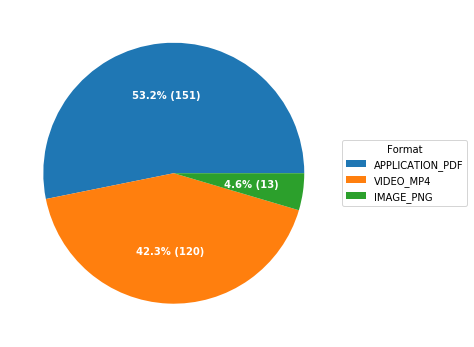

In [9]:
# format
formatCol = lom_df2[['format']]


labels=['APPLICATION_PDF', 'VIDEO_MP4', 'IMAGE_PNG']
values = formatCol['format'].value_counts()

pieChart(values, labels, legendTitle = "Format", title="")

### Interactvity Type

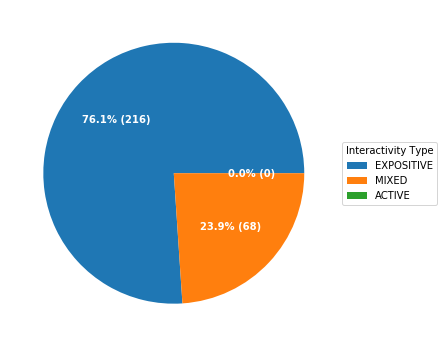

In [10]:
# interactivityType

interactivityTypeCol = lom_df2[['interactivityType']]

labels = ['EXPOSITIVE', 'MIXED', 'ACTIVE']
values = interactivityTypeCol['interactivityType'].value_counts().append(pd.Series({'InteractivityType.ACTIVE': 0}))

pieChart(values, labels, legendTitle = "Interactivity Type", title="")

### Interactivity Level

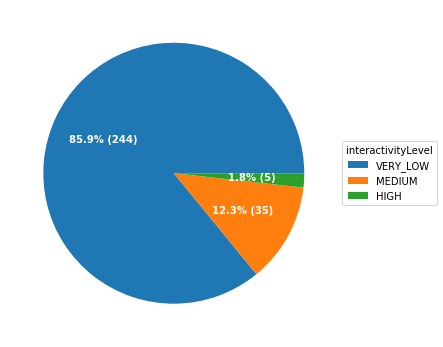

In [11]:
interactivityLevelCol = lom_df2[['interactivityLevel']]

labels = ['VERY_LOW', 'MEDIUM', 'HIGH']
values = interactivityLevelCol['interactivityLevel'].value_counts()

pieChart(values, labels, legendTitle = "interactivityLevel", title="")

### Difficulty

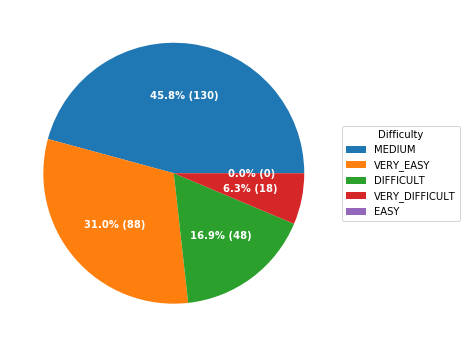

In [12]:
difficultyCol = lom_df2[['difficulty']]

labels = ['MEDIUM', 'VERY_EASY', 'DIFFICULT', 'VERY_DIFFICULT', 'EASY']
values = difficultyCol['difficulty'].value_counts().append(pd.Series({'Difficulty.EASY': 0}))
#values
pieChart(values, labels, legendTitle = "Difficulty", title="")

###  Learning Resource Type

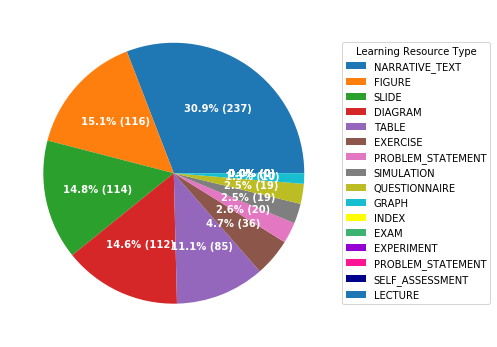

In [13]:
learningResourceTypeCol = lom_df2[['learningResourceType'+str(i) for i in range(8)]]
learningResourceTypeCol.apply(pd.value_counts).fillna(0)
learningResourceTypeCol.stack().value_counts()

labels= ['NARRATIVE_TEXT', 'FIGURE', 'SLIDE', 'DIAGRAM', 'TABLE', 'EXERCISE', 'PROBLEM_STATEMENT', 'SIMULATION', 'QUESTIONNAIRE', 'GRAPH', 'INDEX', 'EXAM', 'EXPERIMENT', 'PROBLEM_STATEMENT', 'SELF_ASSESSMENT', 'LECTURE']
values = learningResourceTypeCol.stack().value_counts().append(pd.Series({'INDEX': 0, 'EXAM': 0, 'EXPERIMENT': 0, 'PROBLEM_STATEMENT': 0, 'SELF_ASSESSMENT': 0, 'LECTURE': 0}))
#values

colors=['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#FFFF00', '#3CB371', '#9400D3', '#FF1493', '#00008B']

pieChart(values, labels, legendTitle = "Learning Resource Type", title="", colors=colors)

### Typical Learning Time

In [14]:
typicalLearningTimeCol = lom_df2[['typicalLearningTime']].applymap(lambda time_str: datetime.datetime.strptime(time_str, '%H:%M:%S').time())

maxTime = datetime.time(0,0,0)
minTime = typicalLearningTimeCol.iloc[0,0]


for time in typicalLearningTimeCol.typicalLearningTime:
    if(time > maxTime):
        maxTime = time
    if(time < minTime):
        minTime = time

print(maxTime)
print(minTime)

13:02:57
00:01:30


In [15]:
listTime = sorted(typicalLearningTimeCol.typicalLearningTime.to_list())

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [(datetime.datetime.min + dt).time() for dt in datetime_range(datetime.timedelta(minutes=5), datetime.timedelta(hours=3, minutes=5), datetime.timedelta(minutes=5))]

timeL = [minTime] + dts + [datetime.time(3, 15), datetime.time(5, 25), datetime.time(6, 15), datetime.time(13, 5) ]

timeDict = {}
for i, time in enumerate(timeL[:-1]):
    timeDict.update({str(timeL[i]) + " - " + str(timeL[i+1]): 0})

    
for duration in listTime:
    for i, time in enumerate(timeL[:-1]):
        if(duration >= timeL[i] and duration <  timeL[i+1]):
            timeDict[str(timeL[i]) + " - " + str(timeL[i+1])] += 1


print(timeDict)
print(sum(timeDict.values()))

{'00:01:30 - 00:05:00': 30, '00:05:00 - 00:10:00': 59, '00:10:00 - 00:15:00': 35, '00:15:00 - 00:20:00': 30, '00:20:00 - 00:25:00': 22, '00:25:00 - 00:30:00': 19, '00:30:00 - 00:35:00': 18, '00:35:00 - 00:40:00': 13, '00:40:00 - 00:45:00': 11, '00:45:00 - 00:50:00': 5, '00:50:00 - 00:55:00': 6, '00:55:00 - 01:00:00': 5, '01:00:00 - 01:05:00': 7, '01:05:00 - 01:10:00': 2, '01:10:00 - 01:15:00': 2, '01:15:00 - 01:20:00': 4, '01:20:00 - 01:25:00': 1, '01:25:00 - 01:30:00': 2, '01:30:00 - 01:35:00': 0, '01:35:00 - 01:40:00': 0, '01:40:00 - 01:45:00': 1, '01:45:00 - 01:50:00': 0, '01:50:00 - 01:55:00': 0, '01:55:00 - 02:00:00': 1, '02:00:00 - 02:05:00': 0, '02:05:00 - 02:10:00': 1, '02:10:00 - 02:15:00': 0, '02:15:00 - 02:20:00': 0, '02:20:00 - 02:25:00': 0, '02:25:00 - 02:30:00': 0, '02:30:00 - 02:35:00': 1, '02:35:00 - 02:40:00': 1, '02:40:00 - 02:45:00': 0, '02:45:00 - 02:50:00': 0, '02:50:00 - 02:55:00': 3, '02:55:00 - 03:00:00': 1, '03:00:00 - 03:15:00': 1, '03:15:00 - 05:25:00': 1, '0

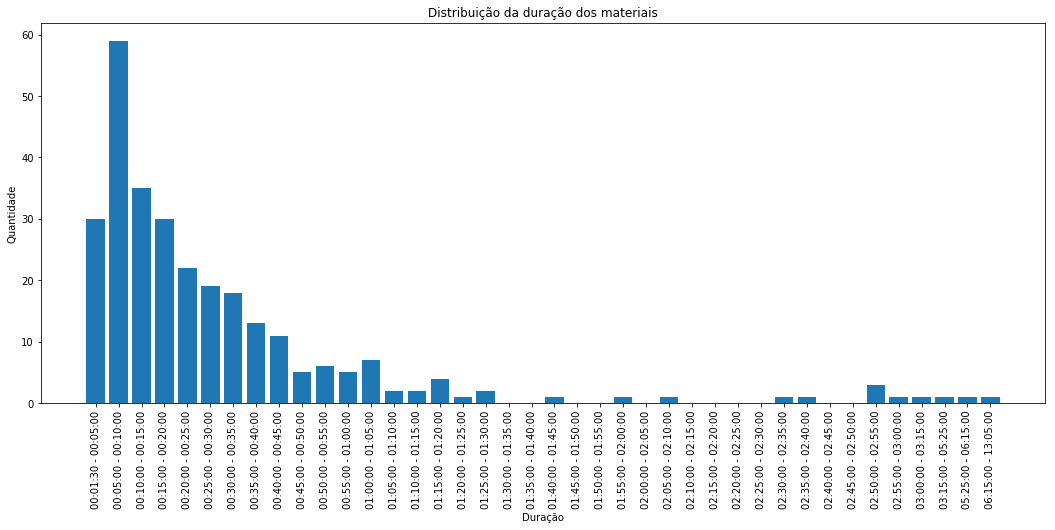

In [16]:
f, ax = plt.subplots(figsize=(18,7))
plt.bar(list(timeDict.keys()), timeDict.values())
plt.xticks(rotation=90)
ax.set_title("Distribuição da duração dos materiais")
plt.xlabel("Duração")
plt.ylabel("Quantidade")
plt.show()

### Quais são os perfis de alunos que a base atende melhor?  

O objetivo aqui é calcular para cada material qual o estilo de aprendizagem ele corresponde dada cada uma das quatro dimensões definidas por FSLSM. Para isso, será utilizada a seguinte tabela definida por MÉNDEZ et al., 2016 e modificado por MACHADO, 2018:

<sup><sup>MÉNDEZ, Nestor D. Duque; MORALES, Valentina Tabares; VICARI, Rosa M. Learning object metadata mapping with learning styles as a strategy for improving usability of educational resource repositories. IEEE Revista Iberoamericana de Tecnologias del Aprendizaje, v. 11, n. 2, p. 101-106, 2016.</sup></sup> <br>
<sup><sup>M. de O. C. Machado, “Geração de Sequências Curriculares Adaptativas baseada no Perfil dos Alunos e Materiais Didáticos utilizando o Algoritmo Presa-Predador” Universidade Federal de Juiz de Fora, 2018.</sup></sup>

In [17]:
learningStyles = ['active', 'reflective', 'sensory', 'intuitive', 'visual', 'verbal', 'sequential', 'global']

labels= ['NARRATIVE_TEXT', 'FIGURE', 'SLIDE', 'DIAGRAM', 'TABLE', 'EXERCISE', 'PROBLEM_STATEMENT', 'SIMULATION', 'QUESTIONNAIRE', 'GRAPH', 'INDEX', 'EXAM', 'EXPERIMENT', 'PROBLEM_STATEMENT', 'SELF_ASSESSMENT', 'LECTURE']

learningResourceTypeIndex = [LearningResourceType.EXERCISE, LearningResourceType.SIMULATION, LearningResourceType.QUESTIONNAIRE, LearningResourceType.DIAGRAM, LearningResourceType.FIGURE, LearningResourceType.GRAPH, LearningResourceType.SLIDE, LearningResourceType.TABLE, LearningResourceType.NARRATIVE_TEXT, LearningResourceType.EXAM, LearningResourceType.EXPERIMENT, LearningResourceType.PROBLEM_STATEMENT, LearningResourceType.SELF_ASSESSMENT, LearningResourceType.LECTURE, InteractivityLevel.VERY_LOW, InteractivityLevel.LOW, InteractivityLevel.MEDIUM, InteractivityLevel.HIGH, InteractivityLevel.VERY_HIGH, InteractivityType.ACTIVE, InteractivityType.EXPOSITIVE, InteractivityType.MIXED]

tab0 = pd.DataFrame(np.array([[1,0,1,0,0,0,1,0], [1,1,1,1,1,0,1,0], [1,0,0,1,0,0,0,0], [0,1,0,1,1,0,1,1], [0,1,0,1,1,0,0,1], [0,1,1,0,1,0,0,1], [0,1,1,1,1,1,1,1], [0,1,1,0,1,0,0,1], [0,1,1,1,0,1,1,1], [1,1,1,1,0,0,0,0], [1,0,1,0,0,0,1,0], [0,1,1,0,0,0,0,0], [1,1,1,1,1,1,1,1], [0,1,1,1,0,1,1,1], [0,0,0,0,0,0,0,0], [1,0,0,0,0,0,0,0], [2,0,0,0,0,0,0,0], [3,0,0,0,0,0,0,0], [4,0,0,0,0,0,0,0], [1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [1,1,0,0,0,0,0,0]]), columns=learningStyles)
tab0.index = learningResourceTypeIndex
tab0

,active,reflective,sensory,intuitive,visual,verbal,sequential,global
LearningResourceType.EXERCISE,1,0,1,0,0,0,1,0
LearningResourceType.SIMULATION,1,1,1,1,1,0,1,0
LearningResourceType.QUESTIONNAIRE,1,0,0,1,0,0,0,0
LearningResourceType.DIAGRAM,0,1,0,1,1,0,1,1
LearningResourceType.FIGURE,0,1,0,1,1,0,0,1
LearningResourceType.GRAPH,0,1,1,0,1,0,0,1
LearningResourceType.SLIDE,0,1,1,1,1,1,1,1
LearningResourceType.TABLE,0,1,1,0,1,0,0,1
LearningResourceType.NARRATIVE_TEXT,0,1,1,1,0,1,1,1
LearningResourceType.EXAM,1,1,1,1,0,0,0,0


Aqui cada material terá uma lista de tamanho oito com o somatório dos seus EA.

In [18]:
tab1 = lom_df2[['identifier','interactivityType', 'interactivityLevel']+ ['learningResourceType'+str(i) for i in range(8)]]
tab1 = tab1.set_index('identifier')

materialStylesPointsList = list()

for index, row in tab1.iterrows(): 
    styles = np.array([0,0,0,0,0,0,0,0])
    for elem in row:
        if not(pd.isna(elem)):
            styles += np.array(tab0.loc[[eval(elem)]].values.tolist()[0]) # ex.:  LearningResourceType.LECTURE -> [0,1,1,1,0,1,1,1] + styles
    
    materialStylesPointsList.append({index: styles.tolist()})
    


Agora será calculado a tendência de cada material para cada uma das opções das dimensões de FSLSM. Esses valores podem ser positivos, negativos ou zero, indicando que não há uma tendência para nenhuma das duas opções.

In [19]:
materialStyles = list()

for material in materialStylesPointsList:
    styles = list()
    for i, style in enumerate(list(material.values())[0][:-4]):
        i *= 2 
        value = list(material.values())[0][i] - list(material.values())[0][i+1]
        if(value > 0):
            styles.append(learningStyles[i])
        elif(value < 0):
            styles.append(learningStyles[i+1])
        else:
            styles.append("neutral_"+str(i))
    materialStyles.append({list(material.keys())[0]: styles})
    
    
sty = [list(dici.values())[0] for dici in materialStyles]
stylesDict = dict(Counter(x for xs in sty for x in set(xs)))

processing = {'active': stylesDict['active'], 'reflective': stylesDict['reflective'], 'neutral': stylesDict['neutral_0']}
print(processing)
perception = {'sensory': stylesDict['sensory'], 'intuitive': stylesDict['intuitive'], 'neutral': stylesDict['neutral_2']}
print(perception)
representation = {'visual': stylesDict['visual'], 'verbal': stylesDict['verbal'], 'neutral': stylesDict['neutral_4']}
print(representation)
understanding = {'sequential': stylesDict['sequential'], 'global': stylesDict['global'], 'neutral': stylesDict['neutral_6']}
print(understanding)


{'active': 18, 'reflective': 251, 'neutral': 15}
{'sensory': 59, 'intuitive': 132, 'neutral': 93}
{'visual': 114, 'verbal': 49, 'neutral': 121}
{'sequential': 18, 'global': 142, 'neutral': 124}


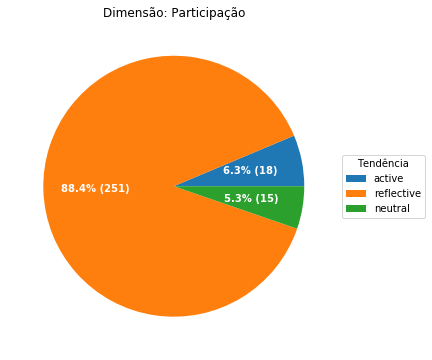

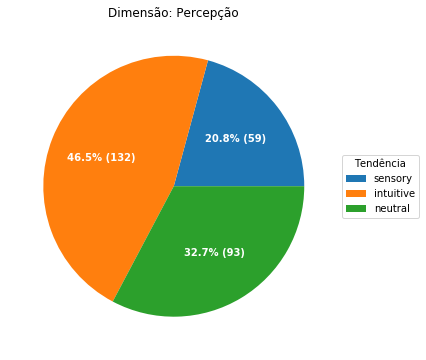

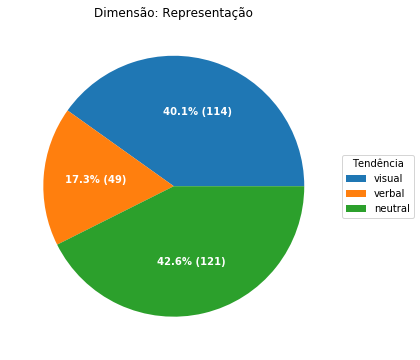

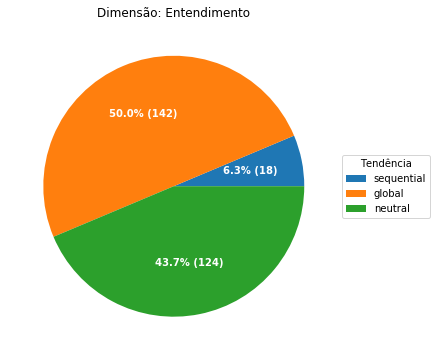

In [20]:
#
pieChart([val for val in processing.values()], ['active', 'reflective','neutral'], legendTitle = "Tendência", title="Dimensão: Participação")
pieChart([val for val in perception.values()], ['sensory', 'intuitive','neutral'], legendTitle = "Tendência", title="Dimensão: Percepção")
pieChart([val for val in representation.values()], ['visual', 'verbal','neutral'], legendTitle = "Tendência", title="Dimensão: Representação")
pieChart([val for val in understanding.values()], ['sequential', 'global','neutral'], legendTitle = "Tendência", title="Dimensão: Entendimento")

O tipo de aluno que a base melhor atende é aquele que apresenta o EA igual a: reflexivo, intuitivo, neutro (ou visual), global.

### Cobertura de Conceitos  

Quantos conceitos cada material cobre?

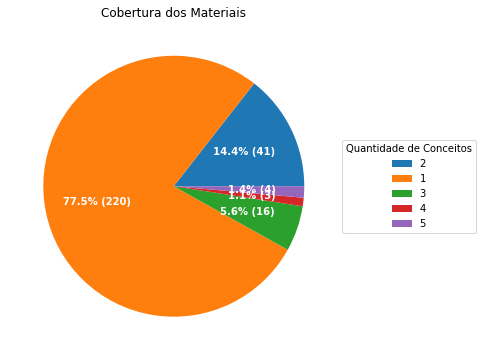

In [21]:
cobertura = pd.read_csv('../evolutionary-computation/instances/real/material_coverage.csv', sep=';', names=['id', 'conceito_1', 'conceito_2', 'conceito_3', 'conceito_4', 'conceito_5'])
cobertura = cobertura.set_index('id')

values = list(Counter(cobertura.count(axis='columns')).values())
pieChart(values,['2', '1', '3', '4', '5'], legendTitle = "Quantidade de Conceitos", title="Cobertura dos Materiais" )

Quais são os conceitos que os materiais cobrem? Distribuição dos conceitos.

In [22]:
quantConceitos = cobertura.stack().value_counts().to_dict()
quantConceitos

{'ICL03': 19,
 'ICSN01': 18,
 'ICFSOOC01': 17,
 'ICFA01': 17,
 'ICRC03': 16,
 'ICFA02': 16,
 'ICRC02': 16,
 'ICL02': 15,
 'ICFBD01': 14,
 'ICSN03': 14,
 'ICFSOOC02': 13,
 'ICRC01': 13,
 'ICES03': 13,
 'ICRC04': 13,
 'ICHCC01': 12,
 'ICFBD02': 12,
 'ICFA03': 12,
 'ICES02': 12,
 'ICRC05': 12,
 'ICFSOOC03': 12,
 'ICES01': 11,
 'ICHCC04': 11,
 'ICHCC05': 11,
 'ICSN02': 11,
 'ICHCC02': 11,
 'ICFBD03': 11,
 'ICHCC03': 11,
 'ICHCC06': 9,
 'ICSN04': 9}

A lista de conceitos não apresenta o conceito 'ICL01' (O que é Lógica) e este conceito também não foi indicado para nenhum aluno.

## Materiais entregues 

Carregar da sequência curricular definida para cada aluno e transformar para array. <br>
Depois fazer um dicio onde o material é a key e o value é uma tupla (quantidadeFalse, quantidadeTrue). <br>


In [23]:

header = ['material_' + str(i) for i in range(0,284)]

data = pd.read_csv(studentXselectedMaterials_file, names=header)

df = pd.DataFrame(data)

dataset = df.apply(pd.Series.value_counts).to_dict() # conta a quantidade de False e True de cada material(coluna)

materialDict = dict() 

for material, materialCount in dataset.items(): # dataset -> {'material_1': {False: 18, True: 6}, ... }
    for key, value in materialCount.items():
        if(np.isnan(value)):
            materialCount[key] = int(0)
        elif(isinstance(value, float)):
            materialCount[key] = int(value)
            
        materialDict[material] = list(materialCount.values())


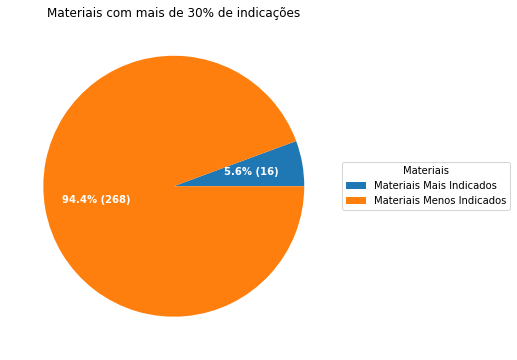

In [24]:
# se um material x foi indicado menos que 30% (17 de 24) das vezes, ou seja, se o número de falso for maior que 17, então:

materiaisMaisEscolhidos = set()
materiaisMenosEscolhidos = set()

for key, value in materialDict.items(): # materialDict -> {'material_1': (18, 6), ...}
    if(value[0] >= 17): #value[0] = False
        materiaisMenosEscolhidos.add(key)
    else:
        materiaisMaisEscolhidos.add(key)
    

labels = ['Materiais Mais Indicados', 'Materiais Menos Indicados']
values = [len(materiaisMaisEscolhidos), len(materiaisMenosEscolhidos)]

pieChart(values, labels, legendTitle = "Materiais", title="Materiais com mais de 30% de indicações")

<b>% de indicações X % de materiais</b>

Counter({0.0: 35.2112676056338, 5.0: 20.070422535211268, 9.0: 13.028169014084506, 13.0: 11.267605633802818, 17.0: 4.929577464788732, 21.0: 3.873239436619718, 30.0: 3.169014084507042, 25.0: 2.8169014084507045, 38.0: 2.8169014084507045, 34.0: 1.4084507042253522, 50.0: 0.7042253521126761, 42.0: 0.35211267605633806, 55.00000000000001: 0.35211267605633806})


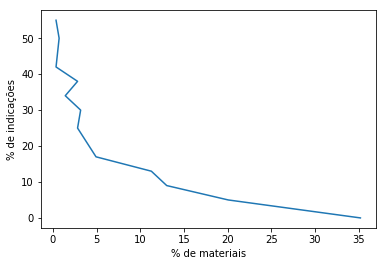

In [25]:
for key, value in materialDict.items():
    materialDict[key] += [round_up(value[1]/(value[0]+ value[1]), 2) ] # porcentagem de indicação

values = Counter([val[2] * 100for val in materialDict.values()]) # porcentagem de indicação: quantidade de materiais

for key, val in values.items(): 
    values[key] = (val/284) * 100
    
print(values) # porcentagem de indicação: porcentagem de materiais

values = OrderedDict(sorted(values.items()))

plt.plot(values.values(),values.keys())
plt.xlabel("% de materiais")
plt.ylabel("% de indicações")
plt.show()

In [26]:
valoresFalsos = pd.Series(value[0] for value in materialDict.values())
valoresVerdadeiros = pd.Series(value[1] for value in materialDict.values())

print("Valores Verdadeiros:\n\n")
print(valoresVerdadeiros.describe())
print("\nMediana de Valores Verdadeiros: " + str(valoresVerdadeiros.median()))

print("Valores Falsos:\n\n")
print(valoresFalsos.describe())
print("\nMediana de Valores Falsos: " + str(valoresFalsos.median()))

Valores Verdadeiros:


count    284.000000
mean       2.112676
std        2.600893
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       13.000000
dtype: float64

Mediana de Valores Verdadeiros: 1.0
Valores Falsos:


count    284.000000
mean      21.887324
std        2.600893
min       11.000000
25%       21.000000
50%       23.000000
75%       24.000000
max       24.000000
dtype: float64

Mediana de Valores Falsos: 23.0


<b>Estilo de aprendizagem: </b>

In [27]:
dictMaterialsLS = dict()

for dici in materialStyles:
    dictMaterialsLS.update(dici)

materials16 = list()
for material in materiaisMaisEscolhidos:
    mat = [int(material.strip('material_'))]
    mat.append(lom_df2.loc[lom_df2['identifier'] == mat[0]].difficulty.values[0])
    mat.append(lom_df2.loc[lom_df2['identifier'] == mat[0]].typicalLearningTime.values[0])
    mat.append(dictMaterialsLS[mat[0]])
    materials16.append(mat)
    
best16 = pd.DataFrame(materials16, columns=['identifier', 'Difficulty', 'typicalLearningTime', 'LS'])
best16

,identifier,Difficulty,typicalLearningTime,LS
0,155,Difficulty.MEDIUM,00:27:35,"[reflective, neutral_2, neutral_4, neutral_6]"
1,143,Difficulty.MEDIUM,00:14:02,"[reflective, intuitive, visual, global]"
2,156,Difficulty.MEDIUM,00:16:11,"[reflective, neutral_2, neutral_4, neutral_6]"
3,184,Difficulty.DIFFICULT,00:46:41,"[reflective, intuitive, visual, global]"
4,239,Difficulty.DIFFICULT,00:30:31,"[reflective, intuitive, neutral_4, global]"
5,212,Difficulty.MEDIUM,00:21:50,"[reflective, sensory, neutral_4, neutral_6]"
6,273,Difficulty.DIFFICULT,00:21:06,"[reflective, intuitive, visual, global]"
7,27,Difficulty.DIFFICULT,00:05:24,"[reflective, intuitive, neutral_4, global]"
8,141,Difficulty.MEDIUM,00:06:41,"[reflective, neutral_2, visual, global]"
9,18,Difficulty.MEDIUM,00:02:00,"[reflective, intuitive, neutral_4, neutral_6]"


In [28]:
best16LS = sum((Counter(x) for x in list(map(Counter, best16.LS))),Counter())

print(best16LS)


Counter({'reflective': 16, 'global': 10, 'intuitive': 9, 'neutral_4': 8, 'visual': 7, 'neutral_2': 6, 'neutral_6': 5, 'sensory': 1, 'verbal': 1, 'sequential': 1})


{'reflective': 16}
{'neutral_2': 6, 'intuitive': 9, 'sensory': 1}
{'neutral_4': 8, 'visual': 7, 'verbal': 1}
{'neutral_6': 5, 'global': 10, 'sequential': 1}


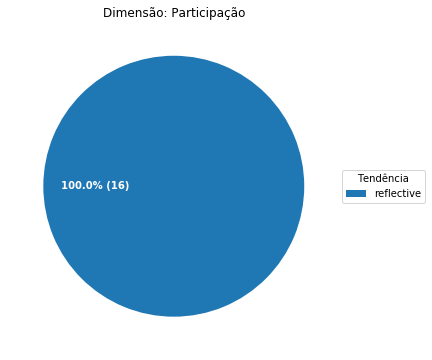

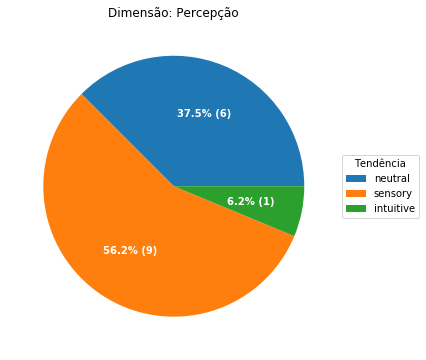

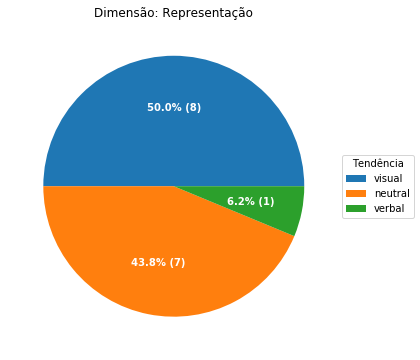

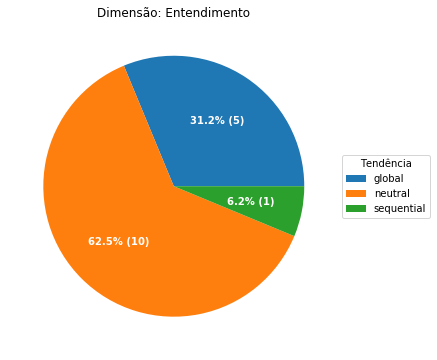

In [29]:
processing16 = { key:value for (key,value) in best16LS.items() if key in ['reflective', 'active','neutral_0'] }
print(processing16)
perception16 = {key:value for (key,value) in best16LS.items() if key in ['intuitive','sensory','neutral_2']}
print(perception16)
representation16 = {key:value for (key,value) in best16LS.items() if key in ['neutral_4','visual', 'verbal']}
print(representation16)
understanding16 = {key:value for (key,value) in best16LS.items() if key in ['global','neutral_6', 'sequential']}
print(understanding16)

pieChart([val for val in processing16.values()] , ['reflective', 'active','neutral'], legendTitle = "Tendência", title="Dimensão: Participação")
pieChart([val for val in perception16.values()], ['neutral','sensory', 'intuitive'], legendTitle = "Tendência", title="Dimensão: Percepção")
pieChart([val for val in representation16.values()], ['visual', 'neutral', 'verbal'], legendTitle = "Tendência", title="Dimensão: Representação")
pieChart([val for val in understanding16.values()], ['global','neutral', 'sequential'], legendTitle = "Tendência", title="Dimensão: Entendimento")


O EA que os materiais mais indicados melhor atendem é: reflexivo, intuitivo, neutro (ou visual), global. O que corresponde com o EA que a base melhor atende.

<b>Cobertura de Conceitos:</b> Quantos conceitos os 16 melhores materiais cobrem?

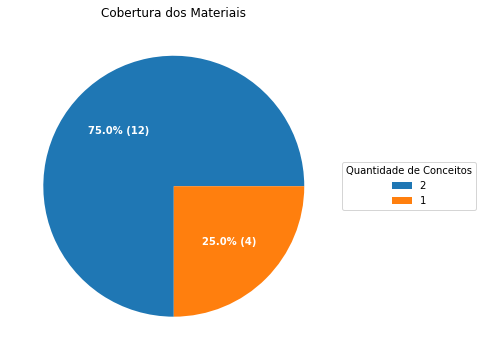

In [30]:
coberturaCount = cobertura.count(axis='columns')
cobertura16 = list()
for material in materiaisMaisEscolhidos:
    mat = [int(material.strip('material_'))]
    mat.append(coberturaCount.loc[mat[0]])
    cobertura16.append(mat[1])
    
pieChart(list(Counter(cobertura16).values()),['2', '1'], legendTitle = "Quantidade de Conceitos", title="Cobertura dos Materiais" )

Quais são os conceitos que os materiais mais indicados cobrem? Distribuição dos conceitos.

In [31]:

quantConceitos16 = list()
for material in materiaisMaisEscolhidos:
    mat = [int(material.strip('material_'))]
    quantConceitos16.append(cobertura.loc[mat[0]-1].value_counts().to_dict())

quantConceitos16 = sum((Counter(x) for x in quantConceitos16),Counter()) 
quantConceitos16

Counter({'ICES03': 2,
         'ICES02': 3,
         'ICES01': 2,
         'ICRC03': 2,
         'ICSN01': 1,
         'ICL03': 1,
         'ICFSOOC02': 1,
         'ICFA02': 4,
         'ICFBD02': 1,
         'ICRC02': 1,
         'ICFA01': 2,
         'ICHCC02': 1})

# Caracterização dos alunos

Utilizando os 24 perfis criados pelo André.

In [32]:
conceito = ['conceitoID_' + str(i) for i in range(1,30)]
learners = pd.read_csv("../evolutionary-computation/instances/real/learners_test.csv", sep=';', names=['id', 'timeMin', 'timeMax', 'ativo_reflexivo', 'sensorial_intuitivo', 'visual_verbal', 'sequencial_global'] + conceito)
learners = learners.set_index('id')
learners = learners.drop(columns=["timeMin"]) # todos os valores são 0
learners.index += 1 
learners.head()

,timeMax,ativo_reflexivo,sensorial_intuitivo,visual_verbal,sequencial_global,conceitoID_1,conceitoID_2,conceitoID_3,conceitoID_4,conceitoID_5,conceitoID_6,conceitoID_7,conceitoID_8,conceitoID_9,conceitoID_10,conceitoID_11,conceitoID_12,conceitoID_13,conceitoID_14,conceitoID_15,conceitoID_16,conceitoID_17,conceitoID_18,conceitoID_19,conceitoID_20,conceitoID_21,conceitoID_22,conceitoID_23,conceitoID_24,conceitoID_25,conceitoID_26,conceitoID_27,conceitoID_28,conceitoID_29
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,11,11,11,11,ICHCC01,ICHCC02,ICHCC03,ICHCC04,ICHCC05,ICHCC06,ICSN01,ICSN02,ICSN03,ICSN04,ICL02,ICL03,ICFA01,ICFA02,ICFA03,ICFBD01,ICFBD02,ICFBD03,ICES01,ICES02,ICES03,ICFSOOC01,ICFSOOC02,ICFSOOC03,ICRC01,ICRC02,ICRC03,ICRC04,ICRC05
2,1,11,11,11,11,ICHCC01,ICHCC02,ICHCC03,ICHCC04,ICHCC05,ICHCC06,ICSN01,ICSN02,ICSN03,ICSN04,ICL02,ICL03,ICFA01,ICFA02,ICFA03,ICFBD01,ICFBD02,ICFBD03,ICES01,ICES02,ICES03,ICFSOOC01,ICFSOOC02,ICFSOOC03,ICRC01,ICRC02,ICRC03,ICRC04,ICRC05
3,1,11,11,11,11,ICHCC01,ICHCC02,ICHCC03,ICHCC04,ICSN01,ICSN02,ICSN03,ICL02,ICL03,ICFA01,ICFA02,ICFBD01,ICFBD02,ICES01,ICES02,ICFSOOC01,ICFSOOC02,ICFSOOC03,ICRC01,ICRC02,ICRC03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,11,11,11,11,ICHCC01,ICHCC02,ICHCC03,ICHCC04,ICSN01,ICSN02,ICSN03,ICL02,ICL03,ICFA01,ICFA02,ICFBD01,ICFBD02,ICES01,ICES02,ICFSOOC01,ICFSOOC02,ICFSOOC03,ICRC01,ICRC02,ICRC03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,11,11,11,11,ICHCC01,ICHCC02,ICSN01,ICL02,ICFBD01,ICES01,ICFSOOC01,ICFSOOC02,ICRC01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
conceitosDF = learners[conceito]
conceitosDF = pd.get_dummies(conceitosDF, prefix="", prefix_sep='',)
conceitosDF = conceitosDF.groupby(level=0, axis=1).sum() # colunas com nomes iguais
conceitosDF.insert(loc=0, column='ICL01', value=pd.Series([int(0) for i in range(25)])) # com valores zerados para todos os alunos,
                                                                                        # pois esse conceito não foi indicado para ninguém
for col in conceitosDF.columns:
    conceitosDF[col]= conceitosDF[col].astype('Int32')
    
conceitosDF.head()

,ICL01,ICES01,ICES02,ICES03,ICFA01,ICFA02,ICFA03,ICFBD01,ICFBD02,ICFBD03,ICFSOOC01,ICFSOOC02,ICFSOOC03,ICHCC01,ICHCC02,ICHCC03,ICHCC04,ICHCC05,ICHCC06,ICL02,ICL03,ICRC01,ICRC02,ICRC03,ICRC04,ICRC05,ICSN01,ICSN02,ICSN03,ICSN04
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0
4,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0
5,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0


In [34]:
learners = learners.drop(columns=conceito)
learners = learners.join(conceitosDF)
learners

,timeMax,ativo_reflexivo,sensorial_intuitivo,visual_verbal,sequencial_global,ICL01,ICES01,ICES02,ICES03,ICFA01,ICFA02,ICFA03,ICFBD01,ICFBD02,ICFBD03,ICFSOOC01,ICFSOOC02,ICFSOOC03,ICHCC01,ICHCC02,ICHCC03,ICHCC04,ICHCC05,ICHCC06,ICL02,ICL03,ICRC01,ICRC02,ICRC03,ICRC04,ICRC05,ICSN01,ICSN02,ICSN03,ICSN04
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,11,11,11,11,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,11,11,11,11,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,11,11,11,11,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0
4,1,11,11,11,11,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0
5,1,11,11,11,11,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
6,1,11,11,11,11,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
7,1,-11,-11,-11,-11,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,1,-11,-11,-11,-11,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9,1,-11,-11,-11,-11,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0


#### Estilo de Aprendizagem 

Dos 24 alunos, existem apenas dois perfis em relação aos EA sendo o primeiro: ativo, sensorial, visal, sequencial e o segundo: reflexivo, intuitivo, verbal, global. No qual o perfil 2 é aquele que a base de materiais melhor atende, por conta disso, os alunos desse perfil apresentam os melhores valores de função de fitness referente ao EA.

## Algoritmos de Categorização 

## Base Real: outra representação dos dados 

Aqui tem-se como objetivo incrementar as características de cada material.

Nesse caso abaixo, se o material cobre mais de um conceito ou não.

In [35]:
moreThanOneConcept = pd.DataFrame.from_dict(cobertura.to_dict()['conceito_2'], orient='index', columns=['MoreThanOneConcept'])
moreThanOneConcept.fillna(0)
moreThanOneConcept['MoreThanOneConcept'] = moreThanOneConcept['MoreThanOneConcept'].apply(lambda x: 1 if type(x) == str else 0)
moreThanOneConcept.head()

,MoreThanOneConcept
0,1
1,1
2,1
3,1
4,1


Qual o estilo de aprendizagem do material?

In [36]:
dataFrame = pd.DataFrame.from_dict(dictMaterialsLS, orient='index', columns=['Processing', 'Perception', 'Representation', 'Understanding'])
dataFrame = pd.get_dummies(dataFrame)
dataFrame = dataFrame[['Processing_active', 'Processing_neutral_0', 'Processing_reflective', 'Perception_sensory', 'Perception_neutral_2','Perception_intuitive', 'Representation_visual' , 'Representation_neutral_4', 'Representation_verbal', 'Understanding_sequential', 'Understanding_neutral_6', 'Understanding_global']]
dataFrame.head()

,Processing_active,Processing_neutral_0,Processing_reflective,Perception_sensory,Perception_neutral_2,Perception_intuitive,Representation_visual,Representation_neutral_4,Representation_verbal,Understanding_sequential,Understanding_neutral_6,Understanding_global
255,0,0,1,0,0,1,1,0,0,0,0,1
269,0,0,1,0,0,1,1,0,0,0,0,1
279,0,0,1,0,0,1,1,0,0,0,0,1
262,0,0,1,0,0,1,1,0,0,0,0,1
278,0,0,1,0,0,1,1,0,0,0,0,1


In [37]:

lomDf = pd.read_csv("../LOM_to_csv1.csv", sep=',')
lomDf = lomDf.drop(columns=['title', 'size'] + ['keyword'+str(i) for i in range(39)])
lomDf = lomDf.set_index('identifier')

# adicionando a característica de recomendação:  
lomDf.insert(loc=0, column='recommendation', value=pd.Series([0 for i in range(285)])) # com valores zerados para todos os materiais

for material, value in materialDict.items(): # adicionando 1 para aqueles que foram indicados para algum aluno
    id1 = int(material.strip('material_'))
    if(value[1] != 0):
        val = 1
    else:
        val = 0
    lomDf.at[id1,'recommendation']= val
    
# conventendo todos os valores para int, com exceção da coluna de tempo
cols=[i for i in lomDf.columns if i not in ["typicalLearningTime"]]

for col in cols:
    lomDf[col]= lomDf[col].astype('Int32')

# convertendo a coluna typicalLearningTime de str para datetime.time em segundos
lomDf[['typicalLearningTime']] = lomDf[['typicalLearningTime']].applymap(lambda time_str: (datetime.datetime.strptime(time_str, '%H:%M:%S') - datetime.datetime(1900, 1, 1)).total_seconds()
)

# adicionando as características de estilo de aprendizagem
lomDf = lomDf.join(dataFrame)

# adicionando a característica moreThanOneConcept, onde caso o material apresente mais de um conceito o valor é 1
lomDf = lomDf.join(moreThanOneConcept)

lomDf.head()   

,recommendation,Format.APPLICATION_PDF,Format.IMAGE_PNG,Format.VIDEO_MP4,InteractivityType.ACTIVE,InteractivityType.EXPOSITIVE,InteractivityType.MIXED,LearningResourceType.EXERCISE,LearningResourceType.SIMULATION,LearningResourceType.QUESTIONNAIRE,LearningResourceType.DIAGRAM,LearningResourceType.FIGURE,LearningResourceType.GRAPH,LearningResourceType.INDEX,LearningResourceType.SLIDE,LearningResourceType.TABLE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.EXAM,LearningResourceType.EXPERIMENT,LearningResourceType.PROBLEM_STATEMENT,LearningResourceType.SELF_ASSESSMENT,LearningResourceType.LECTURE,InteractivityLevel.VERY_LOW,InteractivityLevel.LOW,InteractivityLevel.MEDIUM,InteractivityLevel.HIGH,InteractivityLevel.VERY_HIGH,Difficulty.VERY_EASY,Difficulty.EASY,Difficulty.MEDIUM,Difficulty.DIFFICULT,Difficulty.VERY_DIFFICULT,typicalLearningTime,Processing_active,Processing_neutral_0,Processing_reflective,Perception_sensory,Perception_neutral_2,Perception_intuitive,Representation_visual,Representation_neutral_4,Representation_verbal,Understanding_sequential,Understanding_neutral_6,Understanding_global,MoreThanOneConcept
identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
255,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,917.0,0,0,1,0,0,1,1,0,0,0,0,1,1
269,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,360.0,0,0,1,0,0,1,1,0,0,0,0,1,0
279,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1146.0,0,0,1,0,0,1,1,0,0,0,0,1,0
262,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2657.0,0,0,1,0,0,1,1,0,0,0,0,1,1
278,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1068.0,0,0,1,0,0,1,1,0,0,0,0,1,0


### Produto cartesiano dos alunos com os materiais 

Com o objetivo de melhorar os resultados obtidos pelo classificador, além de utilizar as característica dos materiais também vamos utilizar as características dos alunos.

A operação de produto cartesiano (cross join) será utilizada para calcular todas as possíveis combinações das linhas de dois datasets: <b>lomDf</b> e <b>learners</b>. <br>
O objetivo é definir se um material de lomDf foi indicado a algum aluno de learners.

<b>1:</b> material selecionado para o aluno <br>
<b>0:</b> material não selecionado para o aluno

In [38]:
header = [str(i) for i in range(0,284)]
studentsSelectedMaterial = pd.read_csv(studentXselectedMaterials_file, names=header)
studentsSelectedMaterial = studentsSelectedMaterial.replace({False:0, True:1})
studentsSelectedMaterial.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
def df_crossjoin(df1, df2, **kwargs):
    df1['_tmpkey'] = 1
    df2['_tmpkey'] = 1

    res = pd.merge(df1, df2, on='_tmpkey', **kwargs).drop('_tmpkey', axis=1)
    res.index = pd.MultiIndex.from_product((df1.index, df2.index))

    df1.drop('_tmpkey', axis=1, inplace=True)
    df2.drop('_tmpkey', axis=1, inplace=True)

    return res

In [40]:
def recommendationValue(col):
    indexes = col.name #(aluno, material)
    return studentsSelectedMaterial.loc[indexes[0], str(indexes[1])]

In [41]:
lomDfX = df_crossjoin(learners, lomDf)
lomDfX["recommendation"] = lomDfX.apply(recommendationValue, axis=1)
lomDfX.head()

timeMax  ativo_reflexivo  sensorial_intuitivo  visual_verbal  \
1 255        1               11                   11             11   
  269        1               11                   11             11   
  279        1               11                   11             11   
  262        1               11                   11             11   
  278        1               11                   11             11   

       sequencial_global  ICL01  ICES01  ICES02  ICES03  ICFA01  ICFA02  \
1 255                 11      0       1       1       1       1       1   
  269                 11      0       1       1       1       1       1   
  279                 11      0       1       1       1       1       1   
  262                 11      0       1       1       1       1       1   
  278                 11      0       1       1       1       1       1   

       ICFA03  ICFBD01  ICFBD02  ICFBD03  ICFSOOC01  ICFSOOC02  ICFSOOC03  \
1 255       1        1        1        1          1          1          1   
  269       1        1        1        1          1          1          1   
  279       1        1        1        1          1          1          1   
  262       1        1        1        1          1          1          1   
  278       1        1        1        1          1          1          1   

       ICHCC01  ICHCC02  ICHCC03  ICHCC04  ICHCC05  ICHCC06  ICL02  ICL03  \
1 255        1        1        1        1        1        1      1      1   
  269        1        1        1        1        1        1      1      1   
  279        1        1        1        1        1        1      1      1   
  262        1        1        1        1        1        1      1      1   
  278        1        1        1        1        1        1      1      1   

       ICRC01  ICRC02  ICRC03  ICRC04  ICRC05  ICSN01  ICSN02  ICSN03  ICSN04  \
1 255       1       1       1       1       1       1       1       1       1   
  269       1       1       1       1       1       1       1       1       1   
  279       1       1       1       1       1       1       1       1       1   
  262       1       1       1       1       1       1       1       1       1   
  278       1       1       1       1       1       1       1       1       1   

       recommendation  Format.APPLICATION_PDF  Format.IMAGE_PNG  \
1 255               0                       1                 0   
  269               1                       0                 1   
  279               0                       1                 0   
  262               0                       0                 0   
  278               0                       1                 0   

       Format.VIDEO_MP4  InteractivityType.ACTIVE  \
1 255                 0                         0   
  269                 0                         0   
  279                 0                         0   
  262                 1                         0   
  278                 0                         0   

       InteractivityType.EXPOSITIVE  InteractivityType.MIXED  \
1 255                             0                        1   
  269                             1                        0   
  279                             1                        0   
  262                             1                        0   
  278                             1                        0   

       LearningResourceType.EXERCISE  LearningResourceType.SIMULATION  \
1 255                              0                                0   
  269                              0                                0   
  279                              0                                0   
  262                              0                                0   
  278                              0                                0   

       LearningResourceType.QUESTIONNAIRE  LearningResourceType.DIAGRAM  \
1 255                                   1                             1   
  269               

In [76]:
len(lomDfX)

6816

### Árvore de decisão 

Ávore de decisão é uma ferramenta de predição e classificação utilizada na área de aprendizagem de máquina. O algoritmo é classificado como um método de aprendizagem supervisionada.

In [91]:
today = datetime.date.today().strftime("%d-%m-%Y")

# método para a criação da Decision Tree (DT)
def createDT(lomDf, exceptFeatures, targetVariable, test_size=0.3, criterion='gini', splitter='best', max_depth=None, min_samples_leaf=1):
    feature_cols = [i for i in lomDf.columns if i not in exceptFeatures]

    X = lomDf[feature_cols] # Features (independente)
    y = lomDf[[targetVariable]] # Target variable (dependente)
    y=y.astype('int')

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1) # 70% training and 30% test


    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    # Model Accuracy, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    report = metrics.classification_report(y_pred, y_test)
    print("\nClassification report:\n", report)
    
    confMat = metrics.confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", confMat)
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    
    saveDir = './Classifiers/Decision_Tree/' + today + '-' + targetVariable + '/'
    
    if not (os.path.exists(saveDir)):
        os.mkdir(saveDir)
    else:
        print("\nDiretório já existente!")
    
    saveModel(clf, saveDir, exceptFeatures, targetVariable, test_size, criterion, splitter, max_depth, min_samples_leaf, accuracy)
    saveDT(saveDir, clf, feature_cols)

In [43]:
# método para salvar o arquivo .dot e a imagem da DT
def saveDT(saveDir, clf, feature_cols, class_names=['0','1']):
    dotfile = saveDir + 'DT-'+today+'.dot'
    dot_data = export_graphviz(clf, out_file=dotfile,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names = feature_cols,class_names = class_names)

    fig = saveDir + 'DT-'+today+'.png'


    # Convert to png
    from subprocess import call
    call(['dot', '-Tpng', dotfile, '-o', fig, '-Gdpi=600'])

    Image(filename = fig)

In [44]:
# método para salvar o modelo e os parâmetros de criação da DT
def saveModel(clf, saveDir, exceptFeatures, targetVariable, test_size, criterion, splitter, max_depth, min_samples_leaf, accuracy):
    # save the model to disk
    filename = saveDir + 'finalized_DT_model-'+today+'.joblib'
    joblib.dump(clf,filename)
    
    # save parameters
    with open(saveDir + 'DT_Parameters-'+today+'.txt', 'w') as f:
        f.write("exceptFeatures: " + str(exceptFeatures))
        f.write("\ntarget: " + str(targetVariable))
        f.write("\ntest_size: " + str(test_size))
        f.write("\ncriterion: " + str(criterion))
        f.write("\nsplitter: " + str(splitter))
        f.write("\nmax_depth: " + str(max_depth))
        f.write("\nmin_samples_leaf: " + str(min_samples_leaf))
        f.write("\n------\naccuracy: " + str(accuracy))
    f.close()


Carregar modelo salvo:

In [ ]:
# load the model from disk
saveDir = './Classifiers/Decision_Tree/' + today + '-' + targetVariable + '/'
filename = saveDir + 'finalized_DT_model-'+today+'.joblib'
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print("Accuracy: ", result)

### Testes:

A <b>targetVariable</b> é a variável dependente a qual queremos determinar. <br>
As <b>exceptFeatures</b> são as variáveis que não vão entrar na lista de variáveis independentes necessárias para a determinação da DT.
- <b>exceptFeatures0:</b> considera apenas os valores neutros de estilo de aprendizagem dos materiais.
- <b>exceptFeatures1:</b> além de considerar as mesmas variáveis que exceptFeatures0, considera também os valores das características (InteractivityType, LearningResourceType e InteractivityLevel) que levam a determinação do estilo de aprendizagem do material 

In [104]:
exceptFeatures0 = ["recommendation", "typicalLearningTime", "Processing_neutral_0", 'Perception_neutral_2', 
                  'Representation_neutral_4', 'Understanding_neutral_6']

exceptFeatures1 = ["recommendation", "Processing_neutral_0", 'Perception_neutral_2', 
                  'Representation_neutral_4', 'Understanding_neutral_6', 'InteractivityType.ACTIVE', 
                  'InteractivityType.EXPOSITIVE', 'InteractivityType.MIXED', 
                  'LearningResourceType.EXERCISE', 'LearningResourceType.SIMULATION', 
                  'LearningResourceType.QUESTIONNAIRE', 'LearningResourceType.DIAGRAM', 
                  'LearningResourceType.FIGURE', 'LearningResourceType.GRAPH', 'LearningResourceType.INDEX', 
                  'LearningResourceType.SLIDE', 'LearningResourceType.TABLE', 'LearningResourceType.NARRATIVE_TEXT', 
                  'LearningResourceType.EXAM', 'LearningResourceType.EXPERIMENT', 
                  'LearningResourceType.PROBLEM_STATEMENT', 'LearningResourceType.SELF_ASSESSMENT', 
                  'LearningResourceType.LECTURE', 'InteractivityLevel.VERY_LOW', 'InteractivityLevel.LOW', 
                  'InteractivityLevel.MEDIUM', 'InteractivityLevel.HIGH', 'InteractivityLevel.VERY_HIGH']

targetVariable = "recommendation"

<b>1.</b> Este teste utiliza o dataframe <b>lomDf</b> (tabela representando apenas a base de materiais), nenhum tipo de corte e não elimina nenhuma característica redundande.

Accuracy: 0.5

Classification report:
               precision    recall  f1-score   support

           0       0.48      0.31      0.38        42
           1       0.51      0.68      0.58        44

   micro avg       0.50      0.50      0.50        86
   macro avg       0.49      0.50      0.48        86
weighted avg       0.50      0.50      0.48        86

Confusion matrix:
 [[13 14]
 [29 30]]

Diretório já existente!


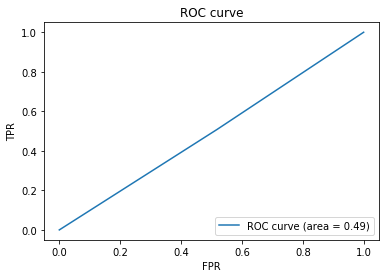

In [90]:
createDT(lomDf, exceptFeatures0, targetVariable)

<b>2.</b> Este teste utiliza o dataframe <b>lomDfX</b> (produto cartesiano dos alunos com os materiais), nenhum tipo de corte e não elimina nenhuma característica redundande.

Accuracy: 0.8865525672371638

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      1955
           1       0.13      0.27      0.17        90

   micro avg       0.89      0.89      0.89      2045
   macro avg       0.55      0.59      0.56      2045
weighted avg       0.93      0.89      0.91      2045

Confusion matrix:
 [[1789   66]
 [ 166   24]]


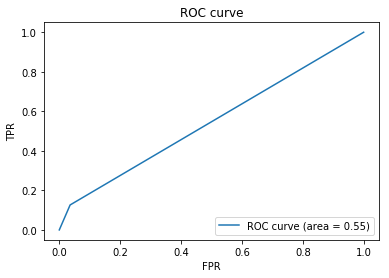


Diretório já existente!


In [92]:
createDT(lomDfX, exceptFeatures0, targetVariable)

<b>3.</b> Este teste utiliza o dataframe <b>lomDf</b>, nenhum tipo de corte e <b>elimina</b> características redundande.

Accuracy: 0.47674418604651164

Classification report:
               precision    recall  f1-score   support

           0       0.30      0.24      0.26        34
           1       0.56      0.63      0.59        52

   micro avg       0.48      0.48      0.48        86
   macro avg       0.43      0.43      0.43        86
weighted avg       0.46      0.48      0.46        86

Confusion matrix:
 [[ 8 19]
 [26 33]]


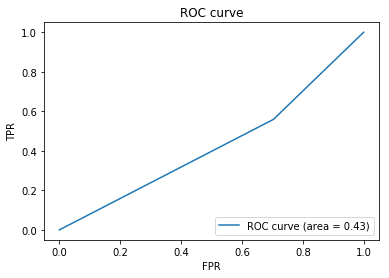


Diretório já existente!


In [105]:
createDT(lomDf, exceptFeatures1, targetVariable)

<b>4.</b> Este teste utiliza o dataframe <b>lomDfX</b>, nenhum tipo de corte e <b>elimina</b> características redundande.

Accuracy: 0.882640586797066

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      1903
           1       0.24      0.32      0.28       142

   micro avg       0.88      0.88      0.88      2045
   macro avg       0.60      0.62      0.61      2045
weighted avg       0.90      0.88      0.89      2045

Confusion matrix:
 [[1759   96]
 [ 144   46]]


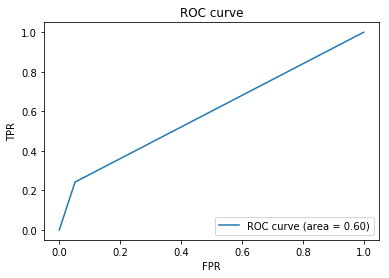


Diretório já existente!


In [106]:
createDT(lomDfX, exceptFeatures1, targetVariable)

<b>Executando os mesmos testes anteriores, porém com poda na árvore:<br>
min_samples_leaf = 10% de 284 ~ 28 </b>

<b>5.</b> Este teste utiliza o dataframe <b>lomDf</b>, poda na árvore e não elimina nenhuma característica redundante.

Accuracy: 0.5116279069767442

Classification report:
               precision    recall  f1-score   support

           0       0.22      0.22      0.22        27
           1       0.64      0.64      0.64        59

   micro avg       0.51      0.51      0.51        86
   macro avg       0.43      0.43      0.43        86
weighted avg       0.51      0.51      0.51        86

Confusion matrix:
 [[ 6 21]
 [21 38]]


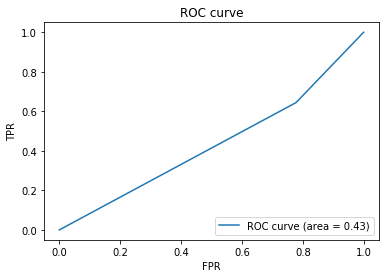


Diretório já existente!


In [95]:
createDT(lomDf, exceptFeatures0, targetVariable, min_samples_leaf=28, max_depth=None)

<b>6.</b> Este teste utiliza o dataframe <b>lomDfX</b>, poda na árvore e não elimina nenhuma característica redundante.

Accuracy: 0.9070904645476773

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95      2045
           1       0.00      0.00      0.00         0

   micro avg       0.91      0.91      0.91      2045
   macro avg       0.50      0.45      0.48      2045
weighted avg       1.00      0.91      0.95      2045

Confusion matrix:
 [[1855    0]
 [ 190    0]]


/opt/anaconda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.

/opt/anaconda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.

/opt/anaconda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



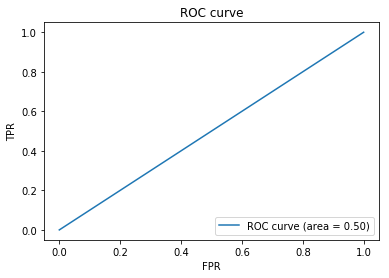


Diretório já existente!


In [96]:
createDT(lomDfX, exceptFeatures0, targetVariable, min_samples_leaf=28, max_depth=None)

<b>7.</b> Este teste utiliza o dataframe <b>lomDf</b>, poda na árvore e <b>elimina</b> características redundantes.

Accuracy: 0.4186046511627907

Classification report:
               precision    recall  f1-score   support

           0       0.30      0.21      0.24        39
           1       0.47      0.60      0.53        47

   micro avg       0.42      0.42      0.42        86
   macro avg       0.39      0.40      0.39        86
weighted avg       0.39      0.42      0.40        86

Confusion matrix:
 [[ 8 19]
 [31 28]]


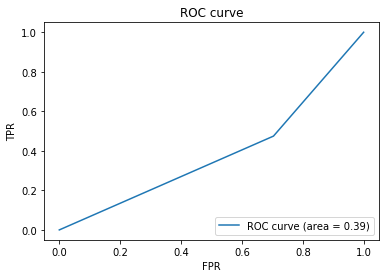


Diretório já existente!


In [107]:
createDT(lomDf, exceptFeatures1, targetVariable, min_samples_leaf=28, max_depth=None)

<b>8.</b> Este teste utiliza o dataframe <b>lomDfX</b>, poda na árvore e <b>elimina</b> características redundantes.

Accuracy: 0.9070904645476773

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95      2045
           1       0.00      0.00      0.00         0

   micro avg       0.91      0.91      0.91      2045
   macro avg       0.50      0.45      0.48      2045
weighted avg       1.00      0.91      0.95      2045

Confusion matrix:
 [[1855    0]
 [ 190    0]]


/opt/anaconda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.

/opt/anaconda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.

/opt/anaconda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



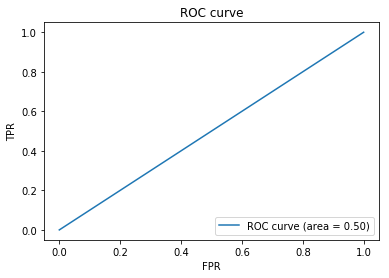


Diretório já existente!


In [109]:
createDT(lomDfX, exceptFeatures1, targetVariable, min_samples_leaf=28, max_depth=None)

O teste que obteve melhor valor de acurácia foi o teste <b>8</b>.


## Random Forest

Accuracy: 0.8865525672371638

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      1925
           1       0.21      0.33      0.25       120

   micro avg       0.89      0.89      0.89      2045
   macro avg       0.58      0.62      0.60      2045
weighted avg       0.91      0.89      0.90      2045

Confusion matrix:
 [[1774   81]
 [ 151   39]]


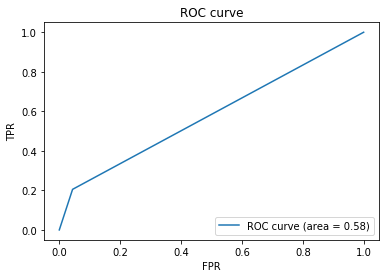

In [110]:
exceptFeatures = ["recommendation", "Processing_neutral_0", 'Perception_neutral_2', 
                  'Representation_neutral_4', 'Understanding_neutral_6', 'InteractivityType.ACTIVE', 
                  'InteractivityType.EXPOSITIVE', 'InteractivityType.MIXED', 
                  'LearningResourceType.EXERCISE', 'LearningResourceType.SIMULATION', 
                  'LearningResourceType.QUESTIONNAIRE', 'LearningResourceType.DIAGRAM', 
                  'LearningResourceType.FIGURE', 'LearningResourceType.GRAPH', 'LearningResourceType.INDEX', 
                  'LearningResourceType.SLIDE', 'LearningResourceType.TABLE', 'LearningResourceType.NARRATIVE_TEXT', 
                  'LearningResourceType.EXAM', 'LearningResourceType.EXPERIMENT', 
                  'LearningResourceType.PROBLEM_STATEMENT', 'LearningResourceType.SELF_ASSESSMENT', 
                  'LearningResourceType.LECTURE', 'InteractivityLevel.VERY_LOW', 'InteractivityLevel.LOW', 
                  'InteractivityLevel.MEDIUM', 'InteractivityLevel.HIGH', 'InteractivityLevel.VERY_HIGH']
targetVariable = "recommendation"

feature_cols = [i for i in lomDfX.columns if i not in exceptFeatures]

X = lomDfX[feature_cols] # Features (independente)
y = lomDfX[[targetVariable]] # Target variable (dependente)
y=y.astype('int')

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train.values.ravel())

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

report = metrics.classification_report(y_pred, y_test)
print("\nClassification report:\n", report)
    
confMat = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", confMat)

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

plt.clf()
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")

feature_imp = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)


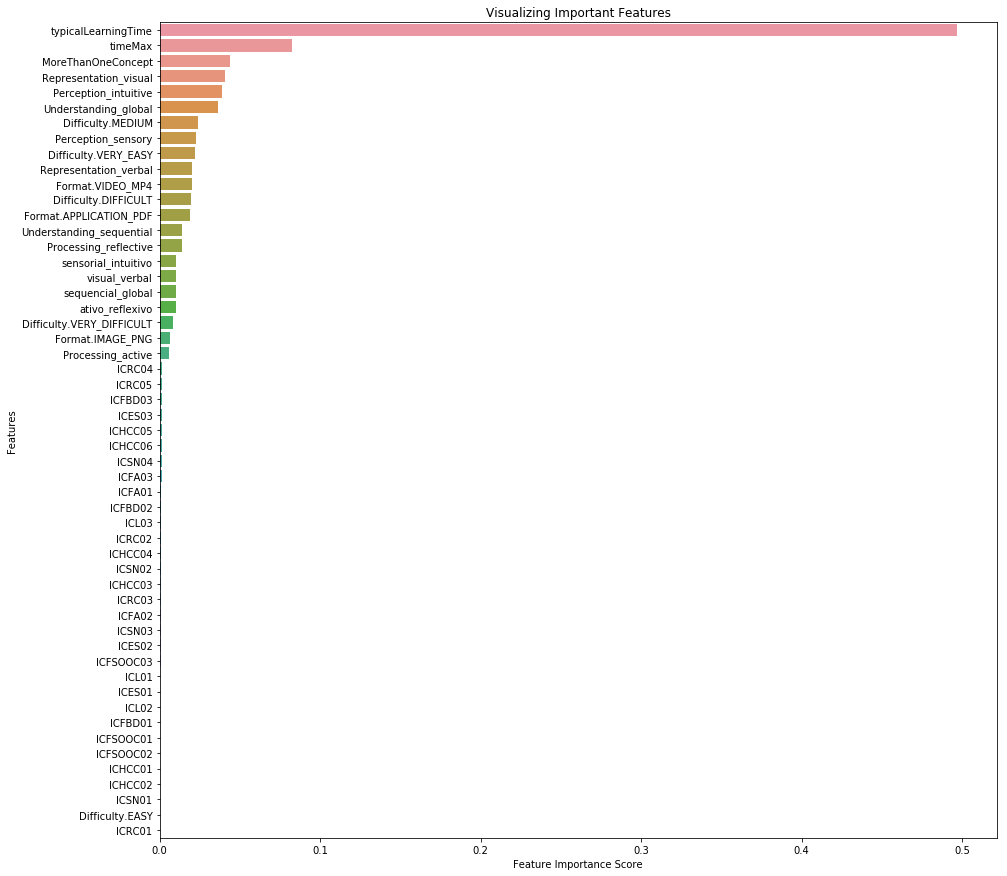

In [111]:
plt.figure(figsize=(15,15))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()
